In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report

import datetime as dt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
train = pd.read_csv('data_train.csv')
alerts = pd.read_csv('alerts.csv')
irreg = pd.read_csv('irregularities.csv')

# Preprocessing: Alerts

In [3]:
train.head()

,Ids,Labels
0,2e69e9384_2020-10-06_13,True
1,2e6992c7c_2020-10-02_17,True
2,2e69ef474_2020-09-13_19,True
3,2e69c5fd4_2020-10-10_15,True
4,2e6992134_2020-09-12_11,True


In [4]:
train.tail()

,Ids,Labels
71331,2e69eea5c_2020-11-09_10,False
71332,2e69c5944_2020-10-27_12,True
71333,2e69f2cd4_2020-11-07_14,True
71334,2e68e64e4_2020-09-23_9,False
71335,2e68e6084_2020-10-18_12,False


In [5]:
alerts.head()

,id,pub_millis,s2id_15,s2token_15,road_type,street,city,magvar,reliability,report_description,report_rating,confidence,type,subtype,report_by_municipality_user,n_thumbs_up,longitude,latitude
0,177876895,1603331480000,3344466888162803712,2e69eeea4,1,NaN,Depok,0,9,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.788545,-6.359846
1,179156987,1604487892000,3344463130066419712,2e69eb7f4,6,N8 Jalan Raya Bogor,Depok,170,7,NaN,1,1,JAM,JAM_HEAVY_TRAFFIC,NaN,0.0,106.867141,-6.383855
2,181688703,1605666614000,3344367648648462336,2e6994a84,7,NaN,Bekasi,0,8,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.921974,-6.379087
3,173055165,1601895721000,3344374458319110144,2e699ad9c,2,Flyover Tegal Gede,Cikarang,319,10,NaN,5,0,WEATHERHAZARD,HAZARD_ON_ROAD_POT_HOLE,NaN,NaN,107.143656,-6.300441
4,173802602,1602464394000,3344466709921660928,2e69eec0c,2,Tanjakan Kembar,Depok,310,5,NaN,3,0,JAM,JAM_HEAVY_TRAFFIC,NaN,NaN,106.793950,-6.365677


## Change millisecond to Date and Time

In [6]:
alerts['pub_date'] = [dt.datetime.fromtimestamp(i/1000.0) for i in alerts['pub_millis']]
alerts['pub_date'].head()

0   2020-10-22 08:51:20
1   2020-11-04 18:04:52
2   2020-11-18 09:30:14
3   2020-10-05 18:02:01
4   2020-10-12 07:59:54
Name: pub_date, dtype: datetime64[ns]

In [7]:
alerts.head()

,id,pub_millis,s2id_15,s2token_15,road_type,street,city,magvar,reliability,report_description,report_rating,confidence,type,subtype,report_by_municipality_user,n_thumbs_up,longitude,latitude,pub_date
0,177876895,1603331480000,3344466888162803712,2e69eeea4,1,NaN,Depok,0,9,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.788545,-6.359846,2020-10-22 08:51:20
1,179156987,1604487892000,3344463130066419712,2e69eb7f4,6,N8 Jalan Raya Bogor,Depok,170,7,NaN,1,1,JAM,JAM_HEAVY_TRAFFIC,NaN,0.0,106.867141,-6.383855,2020-11-04 18:04:52
2,181688703,1605666614000,3344367648648462336,2e6994a84,7,NaN,Bekasi,0,8,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.921974,-6.379087,2020-11-18 09:30:14
3,173055165,1601895721000,3344374458319110144,2e699ad9c,2,Flyover Tegal Gede,Cikarang,319,10,NaN,5,0,WEATHERHAZARD,HAZARD_ON_ROAD_POT_HOLE,NaN,NaN,107.143656,-6.300441,2020-10-05 18:02:01
4,173802602,1602464394000,3344466709921660928,2e69eec0c,2,Tanjakan Kembar,Depok,310,5,NaN,3,0,JAM,JAM_HEAVY_TRAFFIC,NaN,NaN,106.793950,-6.365677,2020-10-12 07:59:54


In [8]:
alerts['pub_date'].head(3)

0   2020-10-22 08:51:20
1   2020-11-04 18:04:52
2   2020-11-18 09:30:14
Name: pub_date, dtype: datetime64[ns]

## Split `dates` and `hour` into Two New Columns

In [9]:
alerts['dates'] = [i.strftime('%Y-%m-%d') for i in alerts['pub_date']]

In [10]:
alerts['hour'] = [str(i.hour) for i in alerts['pub_date']]

In [11]:
alerts.head()

,id,pub_millis,s2id_15,s2token_15,road_type,street,city,magvar,reliability,report_description,report_rating,confidence,type,subtype,report_by_municipality_user,n_thumbs_up,longitude,latitude,pub_date,dates,hour
0,177876895,1603331480000,3344466888162803712,2e69eeea4,1,NaN,Depok,0,9,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.788545,-6.359846,2020-10-22 08:51:20,2020-10-22,8
1,179156987,1604487892000,3344463130066419712,2e69eb7f4,6,N8 Jalan Raya Bogor,Depok,170,7,NaN,1,1,JAM,JAM_HEAVY_TRAFFIC,NaN,0.0,106.867141,-6.383855,2020-11-04 18:04:52,2020-11-04,18
2,181688703,1605666614000,3344367648648462336,2e6994a84,7,NaN,Bekasi,0,8,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.921974,-6.379087,2020-11-18 09:30:14,2020-11-18,9
3,173055165,1601895721000,3344374458319110144,2e699ad9c,2,Flyover Tegal Gede,Cikarang,319,10,NaN,5,0,WEATHERHAZARD,HAZARD_ON_ROAD_POT_HOLE,NaN,NaN,107.143656,-6.300441,2020-10-05 18:02:01,2020-10-05,18
4,173802602,1602464394000,3344466709921660928,2e69eec0c,2,Tanjakan Kembar,Depok,310,5,NaN,3,0,JAM,JAM_HEAVY_TRAFFIC,NaN,NaN,106.793950,-6.365677,2020-10-12 07:59:54,2020-10-12,7


## Combine `s2token_15`, `dates` and `hour` into ids for Merging with Train DF

In [12]:
alerts['Ids'] = alerts['s2token_15']+'_'+alerts['dates']+'_'+alerts['hour']

In [13]:
alerts.head()

,id,pub_millis,s2id_15,s2token_15,road_type,street,city,magvar,reliability,report_description,report_rating,confidence,type,subtype,report_by_municipality_user,n_thumbs_up,longitude,latitude,pub_date,dates,hour,Ids
0,177876895,1603331480000,3344466888162803712,2e69eeea4,1,NaN,Depok,0,9,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.788545,-6.359846,2020-10-22 08:51:20,2020-10-22,8,2e69eeea4_2020-10-22_8
1,179156987,1604487892000,3344463130066419712,2e69eb7f4,6,N8 Jalan Raya Bogor,Depok,170,7,NaN,1,1,JAM,JAM_HEAVY_TRAFFIC,NaN,0.0,106.867141,-6.383855,2020-11-04 18:04:52,2020-11-04,18,2e69eb7f4_2020-11-04_18
2,181688703,1605666614000,3344367648648462336,2e6994a84,7,NaN,Bekasi,0,8,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.921974,-6.379087,2020-11-18 09:30:14,2020-11-18,9,2e6994a84_2020-11-18_9
3,173055165,1601895721000,3344374458319110144,2e699ad9c,2,Flyover Tegal Gede,Cikarang,319,10,NaN,5,0,WEATHERHAZARD,HAZARD_ON_ROAD_POT_HOLE,NaN,NaN,107.143656,-6.300441,2020-10-05 18:02:01,2020-10-05,18,2e699ad9c_2020-10-05_18
4,173802602,1602464394000,3344466709921660928,2e69eec0c,2,Tanjakan Kembar,Depok,310,5,NaN,3,0,JAM,JAM_HEAVY_TRAFFIC,NaN,NaN,106.793950,-6.365677,2020-10-12 07:59:54,2020-10-12,7,2e69eec0c_2020-10-12_7


## Make Function to Simplifies The Proccess

In [14]:
def make_ids(df, col_millis, col_token):
    df['pub_date'] = [dt.datetime.fromtimestamp(i/1000.0) for i in df[col_millis]]
    df['dates'] = [i.strftime('%Y-%m-%d') for i in df['pub_date']]
    df['hour'] = [str(i.hour) for i in df['pub_date']]
    df['Ids'] = df[col_token]+'_'+df['dates']+'_'+df['hour']
    return df

# Preprocessing `irregularities`

In [15]:
irreg.head()

,id,detection_date_millis,update_date_millis,street,city,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type,severity,jam_level,drivers_count,alerts_count,n_thumbs_up
0,12868069,1604733149024,1604735467276,Jatiwaringin Raya,Bekasi,t,"{""line"": [{""x"": 106.91014, ""y"": -6.258107}, {""...",3344471185277583360,2e69f2d2c,13.03,17.15,299,432,1566,0,Small,5,3,13,0,0
1,12420463,1599906813144,1599909295834,Putri Tunggal,Depok,f,"{""line"": [{""x"": 106.887821, ""y"": -6.377016}, {...",3344462996922433536,2e69eb604,6.56,18.00,399,539,984,0,Small,5,3,5,0,0
2,12497533,1601728355356,1601734996933,Ir Haji Juanda,Bandung,f,"{""line"": [{""x"": 107.618629, ""y"": -6.87556}, {""...",3344176694402482176,2e68e6fc4,3.36,19.65,1185,1294,1212,1,Large,5,4,21,2,0
3,12536831,1602312860279,1602315706305,KH Muchtar Tabrani,Bekasi,f,"{""line"": [{""x"": 107.002934, ""y"": -6.216088}, {...",3344358143885836288,2e698c034,4.36,8.04,467,543,659,-1,Small,5,4,3,0,0
4,12327151,1598956623240,1598957378934,N1 Pangeran Diponegoro,Tambun Selatan,t,"{""line"": [{""x"": 107.035652, ""y"": -6.255471}, {...",3344360723013697536,2e698e5bc,4.74,16.71,423,474,625,0,Small,5,4,11,0,0


In [16]:
irreg_up = make_ids(irreg, 'update_date_millis', 's2token_center')

In [17]:
irreg_det = make_ids(irreg, 'detection_date_millis', 's2token_center')

# Joining

In [18]:
test = pd.read_csv('data_test.csv')
test.shape

(13841, 1)

In [19]:
train.shape

(71336, 2)

In [20]:
alerts.shape

(7800662, 22)

In [21]:
display(train.head(1))
display(test.head(1))
display(alerts.head(1))
display(irreg_up.head(1))

,Ids,Labels
0,2e69e9384_2020-10-06_13,True


,Ids
0,2e6992a84_2020-11-25_18


,id,pub_millis,s2id_15,s2token_15,road_type,street,city,magvar,reliability,report_description,report_rating,confidence,type,subtype,report_by_municipality_user,n_thumbs_up,longitude,latitude,pub_date,dates,hour,Ids
0,177876895,1603331480000,3344466888162803712,2e69eeea4,1,NaN,Depok,0,9,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.788545,-6.359846,2020-10-22 08:51:20,2020-10-22,8,2e69eeea4_2020-10-22_8


,id,detection_date_millis,update_date_millis,street,city,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type,severity,jam_level,drivers_count,alerts_count,n_thumbs_up,pub_date,dates,hour,Ids
0,12868069,1604733149024,1604735467276,Jatiwaringin Raya,Bekasi,t,"{""line"": [{""x"": 106.91014, ""y"": -6.258107}, {""...",3344471185277583360,2e69f2d2c,13.03,17.15,299,432,1566,0,Small,5,3,13,0,0,2020-11-07 14:12:29.024,2020-11-07,14,2e69f2d2c_2020-11-07_14


In [22]:
merge_train_alerts = pd.merge(train, alerts, on=['Ids'])

In [23]:
data = pd.merge(merge_train_alerts, irreg_up, on=['Ids'])

In [24]:
data.shape

(3707448, 47)

In [25]:
data.head()

,Ids,Labels,id_x,pub_millis,s2id_15,s2token_15,road_type,street_x,city_x,magvar,reliability,report_description,report_rating,confidence,type_x,subtype,report_by_municipality_user,n_thumbs_up_x,longitude,latitude,pub_date_x,dates_x,hour_x,id_y,detection_date_millis,update_date_millis,street_y,city_y,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type_y,severity,jam_level,drivers_count,alerts_count,n_thumbs_up_y,pub_date_y,dates_y,hour_y
0,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454338,1601005939233,1601008279450,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.040272, ""y"": -6.268992}, {...",3344360639261835264,2e698e484,6.75,25.63,362,440,827,1,Small,5,4,7,0,0,2020-09-25 10:52:19.233,2020-09-25,10
1,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454321,1601005939233,1601007955894,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.03547, ""y"": -6.267191}, {""...",3344360639261835264,2e698e484,8.01,30.29,500,625,1394,1,Medium,5,4,7,0,0,2020-09-25 10:52:19.233,2020-09-25,10
2,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454341,1601005939233,1601008357781,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.040272, ""y"": -6.268992}, {...",3344360639261835264,2e698e484,6.78,25.61,360,438,827,0,Small,5,4,6,0,0,2020-09-25 10:52:19.233,2020-09-25,10
3,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454315,1601005939233,1601007798478,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.03547, ""y"": -6.267191}, {""...",3344360639261835264,2e698e484,9.14,30.45,423,548,1394,-1,Small,5,3,7,0,0,2020-09-25 10:52:19.233,2020-09-25,10
4,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454330,1601005939233,1601008114231,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.040272, ""y"": -6.268992}, {...",3344360639261835264,2e698e484,8.12,26.33,288,366,827,0,Small,5,4,7,0,0,2020-09-25 10:52:19.233,2020-09-25,10


## EDA

In [26]:
data.head(1)

,Ids,Labels,id_x,pub_millis,s2id_15,s2token_15,road_type,street_x,city_x,magvar,reliability,report_description,report_rating,confidence,type_x,subtype,report_by_municipality_user,n_thumbs_up_x,longitude,latitude,pub_date_x,dates_x,hour_x,id_y,detection_date_millis,update_date_millis,street_y,city_y,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type_y,severity,jam_level,drivers_count,alerts_count,n_thumbs_up_y,pub_date_y,dates_y,hour_y
0,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454338,1601005939233,1601008279450,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.040272, ""y"": -6.268992}, {...",3344360639261835264,2e698e484,6.75,25.63,362,440,827,1,Small,5,4,7,0,0,2020-09-25 10:52:19.233,2020-09-25,10


In [27]:
(data.isna().sum()/len(data)*100).sort_values(ascending=False).head(10)

report_description             100.000000
report_by_municipality_user    100.000000
n_thumbs_up_x                   76.760591
subtype                          4.640524
street_x                         3.114649
street_y                         0.900458
report_rating                    0.000000
pub_date_x                       0.000000
latitude                         0.000000
longitude                        0.000000
dtype: float64

**Note**: We can delete columns that contain a lot of NaN values. The following is also the column that has no relationship with the target variable.

In [28]:
data.describe()

,id_x,pub_millis,s2id_15,road_type,magvar,reliability,report_description,report_rating,confidence,report_by_municipality_user,n_thumbs_up_x,longitude,latitude,id_y,detection_date_millis,update_date_millis,s2id_center,speed,regular_speed,delay_seconds,seconds,length,trend,severity,jam_level,drivers_count,alerts_count,n_thumbs_up_y
count,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06,0.0,3.707448e+06,3.707448e+06,0.0,861589.0,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06,3707448.0,3.707448e+06,3.707448e+06,3.707448e+06,3.707448e+06
mean,1.764340e+08,1.603416e+12,3.344330e+18,4.891745e+00,1.625304e+02,5.642938e+00,NaN,1.759216e+00,1.692776e-01,NaN,0.0,1.071354e+02,-6.540876e+00,1.269784e+07,1.603416e+12,1.603419e+12,3.344330e+18,6.366959e+00,2.078335e+01,6.611974e+02,7.817901e+02,1.265223e+03,-1.781204e-01,5.0,3.759645e+00,1.097375e+01,9.342653e-01,3.293530e-01
std,3.912717e+06,1.660056e+09,1.148454e+14,2.581285e+00,1.181746e+02,1.024156e+00,NaN,1.389461e+00,5.446661e-01,NaN,0.0,3.473850e-01,2.697997e-01,1.815409e+05,1.659972e+09,1.660245e+09,1.148454e+14,3.198366e+00,1.068939e+01,3.823192e+02,4.053880e+02,7.400426e+02,7.858336e-01,0.0,4.440751e-01,8.998078e+00,1.438933e+00,1.058309e+00
min,1.663211e+08,1.598920e+12,3.344137e+18,1.000000e+00,0.000000e+00,5.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.0,1.067219e+02,-6.961995e+00,1.232388e+07,1.598920e+12,1.598921e+12,3.344137e+18,5.700000e-01,3.750000e+00,6.900000e+01,1.200000e+02,5.000000e+02,-1.000000e+00,5.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.735164e+08,1.602319e+12,3.344178e+18,2.000000e+00,5.400000e+01,5.000000e+00,NaN,1.000000e+00,0.000000e+00,NaN,0.0,1.069011e+02,-6.880992e+00,1.254033e+07,1.602319e+12,1.602321e+12,3.344178e+18,4.000000e+00,1.489000e+01,4.450000e+02,5.380000e+02,7.160000e+02,-1.000000e+00,5.0,4.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00
50%,1.776130e+08,1.603854e+12,3.344361e+18,6.000000e+00,1.660000e+02,5.000000e+00,NaN,2.000000e+00,0.000000e+00,NaN,0.0,1.069605e+02,-6.395953e+00,1.268745e+07,1.603857e+12,1.603859e+12,3.344361e+18,5.650000e+00,1.921000e+01,5.830000e+02,6.920000e+02,1.027000e+03,0.000000e+00,5.0,4.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00
75%,1.794791e+08,1.604660e+12,3.344425e+18,7.000000e+00,2.670000e+02,6.000000e+00,NaN,3.000000e+00,0.000000e+00,NaN,0.0,1.076023e+02,-6.308303e+00,1.285582e+07,1.604661e+12,1.604663e+12,3.344425e+18,7.960000e+00,2.487000e+01,7.750000e+02,9.250000e+02,1.542000e+03,0.000000e+00,5.0,4.000000e+00,1.400000e+01,1.000000e+00,0.000000e+00
max,1.821552e+08,1.606042e+12,3.344471e+18,2.200000e+01,3.590000e+02,1.000000e+01,NaN,5.000000e+00,5.000000e+00,NaN,0.0,1.077158e+02,-6.160888e+00,1.306029e+07,1.606042e+12,1.606048e+12,3.344471e+18,2.865000e+01,1.832770e+03,7.053000e+03,5.217000e+03,6.191000e+03,1.000000e+00,5.0,4.000000e+00,1.000000e+02,1.500000e+01,2.500000e+01


In [29]:
# !pip install s2cell

In [30]:
import s2cell

In [31]:
coor = [s2cell.token_to_lat_lon(i) for i in data['s2token_15']]

In [32]:
coor = np.array(coor)

In [33]:
data['lat'] = coor[:,0]
data['lon'] = coor[:,1]

In [34]:
data.head(1)

,Ids,Labels,id_x,pub_millis,s2id_15,s2token_15,road_type,street_x,city_x,magvar,reliability,report_description,report_rating,confidence,type_x,subtype,report_by_municipality_user,n_thumbs_up_x,longitude,latitude,pub_date_x,dates_x,hour_x,id_y,detection_date_millis,update_date_millis,street_y,city_y,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type_y,severity,jam_level,drivers_count,alerts_count,n_thumbs_up_y,pub_date_y,dates_y,hour_y,lat,lon
0,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454338,1601005939233,1601008279450,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.040272, ""y"": -6.268992}, {...",3344360639261835264,2e698e484,6.75,25.63,362,440,827,1,Small,5,4,7,0,0,2020-09-25 10:52:19.233,2020-09-25,10,-6.270088,107.043609


In [35]:
data['day'] = data['pub_date_y'].dt.day
data['month'] = data['pub_date_y'].dt.month

In [36]:
data.head(1)

,Ids,Labels,id_x,pub_millis,s2id_15,s2token_15,road_type,street_x,city_x,magvar,reliability,report_description,report_rating,confidence,type_x,subtype,report_by_municipality_user,n_thumbs_up_x,longitude,latitude,pub_date_x,dates_x,hour_x,id_y,detection_date_millis,update_date_millis,street_y,city_y,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type_y,severity,jam_level,drivers_count,alerts_count,n_thumbs_up_y,pub_date_y,dates_y,hour_y,lat,lon,day,month
0,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454338,1601005939233,1601008279450,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.040272, ""y"": -6.268992}, {...",3344360639261835264,2e698e484,6.75,25.63,362,440,827,1,Small,5,4,7,0,0,2020-09-25 10:52:19.233,2020-09-25,10,-6.270088,107.043609,25,9


In [37]:
dict_road_type = {}
for i in data['s2token_15'].unique():    
    dict_road_type[i] = data[data['s2token_15']==i]['road_type'].unique()[0]

KeyboardInterrupt: 

In [38]:
data[data['s2token_15']==data['s2token_15'].unique()[2]]['street_x'].unique()

array([nan, 'KH Noer Ali', 'Arah Tol Jkt-Cikampek/Tol Lkr Dalam/Cawang'],
      dtype=object)

In [39]:
data['token_hour'] = [i.split('_')[0]+'_'+i.split('_')[-1] for i in data['Ids']]

In [40]:
data['token_hour'].nunique()

2580

In [133]:
data.head()

,Ids,Labels,id_x,pub_millis,s2id_15,s2token_15,road_type,street_x,city_x,magvar,reliability,report_description,report_rating,confidence,type_x,subtype,report_by_municipality_user,n_thumbs_up_x,longitude,latitude,pub_date_x,dates_x,hour_x,id_y,detection_date_millis,update_date_millis,street_y,city_y,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type_y,severity,jam_level,drivers_count,alerts_count,n_thumbs_up_y,pub_date_y,dates_y,hour_y,lat,lon,day,month,token_hour
0,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454338,1601005939233,1601008279450,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.040272, ""y"": -6.268992}, {...",3344360639261835264,2e698e484,6.75,25.63,362,440,827,1,Small,5,4,7,0,0,2020-09-25 10:52:19.233,2020-09-25,10,-6.270088,107.043609,25,9,2e698e484_10
1,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454321,1601005939233,1601007955894,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.03547, ""y"": -6.267191}, {""...",3344360639261835264,2e698e484,8.01,30.29,500,625,1394,1,Medium,5,4,7,0,0,2020-09-25 10:52:19.233,2020-09-25,10,-6.270088,107.043609,25,9,2e698e484_10
2,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454341,1601005939233,1601008357781,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.040272, ""y"": -6.268992}, {...",3344360639261835264,2e698e484,6.78,25.61,360,438,827,0,Small,5,4,6,0,0,2020-09-25 10:52:19.233,2020-09-25,10,-6.270088,107.043609,25,9,2e698e484_10
3,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454315,1601005939233,1601007798478,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.03547, ""y"": -6.267191}, {""...",3344360639261835264,2e698e484,9.14,30.45,423,548,1394,-1,Small,5,3,7,0,0,2020-09-25 10:52:19.233,2020-09-25,10,-6.270088,107.043609,25,9,2e698e484_10
4,2e698e484_2020-09-25_10,True,170560751,1601003424000,3344360639261835264,2e698e484,2,Lambang Jaya,Tambun Selatan,109,6,NaN,2,0,JAM,JAM_STAND_STILL_TRAFFIC,NaN,0.0,107.044226,-6.270431,2020-09-25 10:10:24,2020-09-25,10,12454330,1601005939233,1601008114231,Lambang Jaya,Tambun Selatan,f,"{""line"": [{""x"": 107.040272, ""y"": -6.268992}, {...",3344360639261835264,2e698e484,8.12,26.33,288,366,827,0,Small,5,4,7,0,0,2020-09-25 10:52:19.233,2020-09-25,10,-6.270088,107.043609,25,9,2e698e484_10


In [140]:
data['speed_decresement_%'] = (data['regular_speed'] - data['speed'])/data['regular_speed']*100

In [141]:
data['speed_decresement_%']

0          73.663675
1          73.555629
2          73.525966
3          69.983580
4          69.160653
             ...    
3707443    75.280199
3707444    75.280199
3707445    75.280199
3707446    74.408189
3707447    74.408189
Name: speed_decresement_%, Length: 3707448, dtype: float64

In [134]:
database_street = data.groupby(['s2token_15', 'street_y']).size().reset_index(name='Freq')
database_road_type = data.groupby(['s2token_15', 'road_type']).size().reset_index(name='Freq')
database_jam_level = data.groupby(['s2token_15', 'jam_level']).size().reset_index(name='Freq')
database_severity = data.groupby(['s2token_15', 'severity']).size().reset_index(name='Freq')

In [148]:
database_speed = data.groupby(['s2token_15', 'speed_decresement_%']).size().reset_index(name='Freq')

In [149]:
database_speed

,s2token_15,speed_decresement_%,Freq
0,2e68c2a5c,75.490394,34
1,2e68c2a64,55.913978,105
2,2e68c2ae4,79.367816,96
3,2e68c2ba4,52.183961,140
4,2e68c2ba4,52.345736,70
...,...,...,...
36805,2e69f2d4c,84.900731,125
36806,2e69f2d4c,85.029586,71
36807,2e69f2d4c,85.877137,35
36808,2e69f2d4c,85.904762,70


In [150]:
db_speed = database_speed.drop(database_speed[database_speed.duplicated('s2token_15', keep='first')].index)

In [151]:
database_severity = data.groupby(['s2token_15', 'severity']).size().reset_index(name='Freq')

In [152]:
db_severity = database_severity.drop(database_severity[database_severity.duplicated('s2token_15', keep='first')].index)

In [ ]:
db_street = database_street.drop(database_street[database_street.duplicated('s2token_15', keep='first')].index)

In [86]:
database_street['s2token_15'].nunique()

947

In [87]:
db_street = database_street.drop(database_street[database_street.duplicated('s2token_15', keep='first')].index)

In [88]:
db_street.drop(columns='Freq', inplace=True)
db_street

,s2token_15,street_y
0,2e68c2a5c,N11 Soekarno-Hatta
1,2e68c2a64,N11 Soekarno-Hatta
2,2e68c2ae4,Terusan Cisaranten Kulon
3,2e68c2ba4,N11 Soekarno-Hatta
4,2e68c2c5c,Soekarno-Hatta (Jalur Lambat)
...,...,...
990,2e69f2ccc,Jatiwaringin Raya
991,2e69f2cd4,Jatiwaringin Raya
992,2e69f2d2c,Jatiwaringin Raya
993,2e69f2d34,Jatiwaringin Raya


In [68]:
db_street['s2token_15'].nunique()

947

In [69]:
db_street.isna().sum()

s2token_15    0
street_x      0
dtype: int64

In [70]:
db_street['street_x'].unique()

array(['Arah Jalur Cepat', 'N11 Soekarno-Hatta',
       'Terusan Cisaranten Kulon', 'Soekarno-Hatta (Jalur Lambat)',
       'Jalan Rumah Sakit', 'Jenderal AH Nasution', 'Golf Barat',
       'Dr Setiabudi', 'Sersan Bajuri', 'N11 Jenderal Haji Amir Machmud',
       'Jenderal Haji Amir Machmud', 'Gang Sukaasih', 'Jalan Gunung Batu',
       'Cijerah Raya', 'Terusan Pasir Koja', 'Jenderal Sudirman',
       'Rajawali Timur', 'Astana Anyar', 'Pajagalan', 'Gardujati',
       'Asia Afrika', 'Jalan ABC', 'Alun-alun Timur', 'Lengkong Besar',
       'Lengkong Kecil', 'Jalan Banda', 'Merdeka', 'Dr Otten',
       'Layang Pasupati', 'Pasteur', 'Cihampelas',
       'Arah Cihampelas/Djunjunan/Tol Pasteur', 'Hariangbanga',
       'Tamansari', 'Ir Haji Juanda', 'Sultan Ageng Tirtayasa',
       'Jalan Halmahera', 'Surapati', 'Cikapayang', 'Dipati Ukur',
       'Dayang Sumbi', 'Bapak Husen', 'RA Wiranatakusumah', 'Sukajadi',
       'Dr Djundjunan', 'Pajajaran', 'Abdul Rahman Saleh',
       'Kapten Tata Nat

In [71]:
database_road_type['s2token_15'].nunique()

951

In [72]:
db_road_type = database_road_type.drop(database_road_type[database_road_type.duplicated('s2token_15', keep='first')].index)

In [73]:
db_road_type.drop(columns='Freq', inplace=True)
db_road_type

,s2token_15,road_type
0,2e68c2a5c,7
1,2e68c2a64,6
2,2e68c2ae4,2
3,2e68c2ba4,6
5,2e68c2c5c,7
...,...,...
1126,2e69f2ccc,1
1128,2e69f2cd4,7
1129,2e69f2d2c,1
1131,2e69f2d34,7


In [74]:
db_jam_level = database_jam_level.drop(database_jam_level[database_jam_level.duplicated('s2token_15', keep='first')].index)

In [75]:
db_jam_level.drop(columns='Freq', inplace=True)
db_jam_level

,s2token_15,jam_level
0,2e68c2a5c,3
1,2e68c2a64,3
2,2e68c2ae4,4
3,2e68c2ba4,2
6,2e68c2c5c,4
...,...,...
1494,2e69f2ccc,3
1496,2e69f2cd4,3
1498,2e69f2d2c,2
1501,2e69f2d34,3


In [76]:
db_jam_level.isna().sum()

s2token_15    0
jam_level     0
dtype: int64

In [164]:
ready = data[['s2token_15','lat', 'lon', 'day', 'month', 'Labels', 'hour_y', 'street_y', 'road_type', 'jam_level', 'speed_decresement_%']]
ready

,s2token_15,lat,lon,day,month,Labels,hour_y,street_y,road_type,jam_level,speed_decresement_%
0,2e698e484,-6.270088,107.043609,25,9,True,10,Lambang Jaya,2,4,73.663675
1,2e698e484,-6.270088,107.043609,25,9,True,10,Lambang Jaya,2,4,73.555629
2,2e698e484,-6.270088,107.043609,25,9,True,10,Lambang Jaya,2,4,73.525966
3,2e698e484,-6.270088,107.043609,25,9,True,10,Lambang Jaya,2,3,69.983580
4,2e698e484,-6.270088,107.043609,25,9,True,10,Lambang Jaya,2,4,69.160653
...,...,...,...,...,...,...,...,...,...,...,...
3707443,2e68e6874,-6.886813,107.581583,22,11,True,17,Prof Dr Surya Sumantri,2,4,75.280199
3707444,2e68e6874,-6.886813,107.581583,22,11,True,17,Prof Dr Surya Sumantri,2,4,75.280199
3707445,2e68e6874,-6.886813,107.581583,22,11,True,17,Prof Dr Surya Sumantri,2,4,75.280199
3707446,2e68e6874,-6.886813,107.581583,22,11,True,17,Prof Dr Surya Sumantri,2,4,74.408189


In [90]:
ready.isna().sum()/len(ready)*100

s2token_15    0.000000
lat           0.000000
lon           0.000000
day           0.000000
month         0.000000
Labels        0.000000
hour_y        0.000000
street_y      0.900458
road_type     0.000000
jam_level     0.000000
dtype: float64

In [92]:
3707448 *0.900458/100

33384.01211184

In [ ]:
db_street['']

In [93]:
ready[ready['street_y'].isna()==True]['s2token_15'].value_counts()

2e698cff4    17795
2e69eeebc    10769
2e698cfec     1802
2e698fe84     1252
2e698c6dc      878
2e69899ac      480
2e69899a4      408
Name: s2token_15, dtype: int64

In [98]:
for i in ready[ready['street_y'].isna()==True]['s2token_15'].value_counts().index:
    print(db_street[db_street['s2token_15']==i])

    s2token_15     street_y
417  2e698cff4  KH Noer Ali
    s2token_15     street_y
976  2e69eeebc  Krukut Raya
    s2token_15     street_y
416  2e698cfec  KH Noer Ali
Empty DataFrame
Columns: [s2token_15, street_y]
Index: []
Empty DataFrame
Columns: [s2token_15, street_y]
Index: []
Empty DataFrame
Columns: [s2token_15, street_y]
Index: []
Empty DataFrame
Columns: [s2token_15, street_y]
Index: []


In [104]:
ready[(ready['s2token_15']=='2e698cff4') & (ready['street_y'].isna()==False)]['street_y'].unique()

array(['KH Noer Ali'], dtype=object)

In [105]:
ready_clean = ready.dropna()

<AxesSubplot:ylabel='Frequency'>

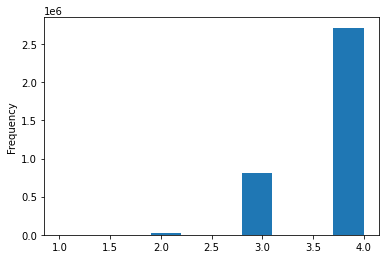

In [106]:
ready_clean[ready_clean['Labels'] == True]['jam_level'].plot(kind='hist')

<AxesSubplot:xlabel='jam_level'>

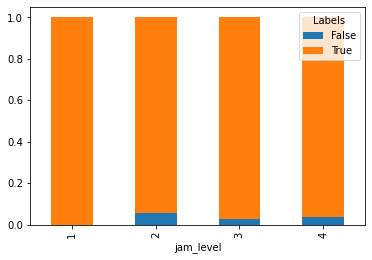

In [107]:
pd.crosstab(index=ready_clean['jam_level'], columns=ready_clean['Labels'], normalize=0).plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='hour_y'>

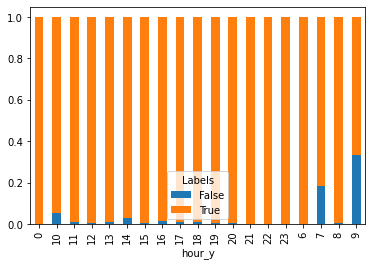

In [58]:
pd.crosstab(index=ready_clean['hour_y'], columns=ready_clean['Labels'], normalize=0).plot(kind='bar', stacked=True)

In [57]:
pd.crosstab(index=ready_clean['jam_level'], columns=ready_clean['Labels'], normalize=0)

Labels,False,True
jam_level,,
1,0.000000,1.000000
2,0.056849,0.943151
3,0.023157,0.976843
4,0.033119,0.966881


In [ ]:
ready[ready['Labels'] == False]['jam_level'].plot(kind='hist')

In [108]:
test = pd.read_csv('data_test.csv')
test

,Ids
0,2e6992a84_2020-11-25_18
1,2e68e62f4_2020-11-29_20
2,2e68e81a4_2020-11-27_10
3,2e69eec04_2020-11-24_7
4,2e698e4a4_2020-11-27_8
...,...
13836,2e68dd414_2020-11-26_5
13837,2e698541c_2020-11-24_22
13838,2e69e8e0c_2020-11-24_10
13839,2e699a1cc_2020-11-24_18


In [118]:
def ids_to_df(df):
    test_df2 = pd.DataFrame()
    test_df2['s2cell_token'] = df['Ids'].str.split('_').apply(lambda x: x[0])
    test_df2['date'] = df['Ids'].str.split('_').apply(lambda x: x[1])
    test_df2['date'] = test_df2['date'].str.split('-')
    test_df2['hour_y'] = df['Ids'].str.split('_').apply(lambda x: x[2])
    test_df2['token_hour'] = test_df2['s2cell_token']+'_'+test_df2['hour_y'] 
    
    test_df2['year'] = test_df2['date'].apply(lambda x: int(x[0]))
    test_df2['month'] = test_df2['date'].apply(lambda x: int(x[1]))
    test_df2['day'] = test_df2['date'].apply(lambda x: int(x[2]))
    test_df2['hour_y'] = test_df2['hour_y'].astype('int')
    
    test_df2['lat'] = test_df2['s2cell_token'].apply(s2cell.token_to_lat_lon).apply(lambda x: x[0])
    test_df2['lon'] = test_df2['s2cell_token'].apply(s2cell.token_to_lat_lon).apply(lambda x: x[1])
    
    test_df2['x'] = np.cos(test_df2['lat']) * np.cos(test_df2['lon'])
    test_df2['y'] = np.cos(test_df2['lat']) * np.sin(test_df2['lon'])
    test_df2['z'] = np.sin(test_df2['lat'])
    
    test_df2 = test_df2[['s2cell_token', 'x', 'y', 'z', 'day', 'month', 'hour_y']]
    test_df2.rename(columns={'s2cell_token': 's2token_15'}, inplace=True)
    
    return test_df2

In [119]:
new_test = ids_to_df(test)

In [120]:
merge_street = pd.merge(new_test, db_street, how='left')
merge_street

,s2token_15,x,y,z,day,month,hour_y,street_y
0,2e6992a84,0.994031,0.108207,-0.013921,25,11,18,Hankam Raya
1,2e68e62f4,0.561143,0.574345,-0.596025,29,11,20,Asia Afrika
2,2e68e81a4,0.525794,0.591784,-0.611009,27,11,10,N11 Soekarno-Hatta
3,2e69eec04,0.996602,-0.021315,-0.079557,24,11,7,NaN
4,2e698e4a4,0.972344,0.233176,0.013294,27,11,8,NaN
...,...,...,...,...,...,...,...,...
13836,2e68dd414,0.520341,0.621773,-0.585357,26,11,5,Jenderal AH Nasution
13837,2e698541c,0.953392,0.301451,0.013105,24,11,22,NaN
13838,2e69e8e0c,0.991486,-0.047556,-0.121218,24,11,10,Muhtar Raya
13839,2e699a1cc,0.951855,0.294791,-0.084091,24,11,18,Cibarusah Raya


In [121]:
merge_road = pd.merge(merge_street, db_road_type, how='left')
merge_road

,s2token_15,x,y,z,day,month,hour_y,street_y,road_type
0,2e6992a84,0.994031,0.108207,-0.013921,25,11,18,Hankam Raya,2.0
1,2e68e62f4,0.561143,0.574345,-0.596025,29,11,20,Asia Afrika,7.0
2,2e68e81a4,0.525794,0.591784,-0.611009,27,11,10,N11 Soekarno-Hatta,6.0
3,2e69eec04,0.996602,-0.021315,-0.079557,24,11,7,NaN,NaN
4,2e698e4a4,0.972344,0.233176,0.013294,27,11,8,NaN,NaN
...,...,...,...,...,...,...,...,...,...
13836,2e68dd414,0.520341,0.621773,-0.585357,26,11,5,Jenderal AH Nasution,6.0
13837,2e698541c,0.953392,0.301451,0.013105,24,11,22,NaN,NaN
13838,2e69e8e0c,0.991486,-0.047556,-0.121218,24,11,10,Muhtar Raya,7.0
13839,2e699a1cc,0.951855,0.294791,-0.084091,24,11,18,Cibarusah Raya,7.0


In [123]:
merge_jam_level = pd.merge(merge_road, db_jam_level, how='left')
merge_jam_level

,s2token_15,x,y,z,day,month,hour_y,street_y,road_type,jam_level
0,2e6992a84,0.994031,0.108207,-0.013921,25,11,18,Hankam Raya,2.0,4.0
1,2e68e62f4,0.561143,0.574345,-0.596025,29,11,20,Asia Afrika,7.0,3.0
2,2e68e81a4,0.525794,0.591784,-0.611009,27,11,10,N11 Soekarno-Hatta,6.0,3.0
3,2e69eec04,0.996602,-0.021315,-0.079557,24,11,7,NaN,NaN,NaN
4,2e698e4a4,0.972344,0.233176,0.013294,27,11,8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
13836,2e68dd414,0.520341,0.621773,-0.585357,26,11,5,Jenderal AH Nasution,6.0,3.0
13837,2e698541c,0.953392,0.301451,0.013105,24,11,22,NaN,NaN,NaN
13838,2e69e8e0c,0.991486,-0.047556,-0.121218,24,11,10,Muhtar Raya,7.0,2.0
13839,2e699a1cc,0.951855,0.294791,-0.084091,24,11,18,Cibarusah Raya,7.0,3.0


In [155]:
merge_speed =  pd.merge(merge_jam_level, db_speed, how='left')

In [160]:
merge_speed.rename(columns={'speed_decresement_%': 'speed_decrease_%'}, inplace=True)

In [156]:
merge_severity =  pd.merge(merge_speed, db_severity, how='left')

In [157]:
merge_severity

,s2token_15,x,y,z,day,month,hour_y,street_y,road_type,jam_level,speed_decresement_%,Freq,severity
0,2e6992a84,0.994031,0.108207,-0.013921,25,11,18,Hankam Raya,2.0,4.0,59.383562,280.0,NaN
1,2e68e62f4,0.561143,0.574345,-0.596025,29,11,20,Asia Afrika,7.0,3.0,42.996743,105.0,NaN
2,2e68e81a4,0.525794,0.591784,-0.611009,27,11,10,N11 Soekarno-Hatta,6.0,3.0,14.737794,32.0,NaN
3,2e69eec04,0.996602,-0.021315,-0.079557,24,11,7,NaN,NaN,NaN,NaN,NaN,NaN
4,2e698e4a4,0.972344,0.233176,0.013294,27,11,8,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13836,2e68dd414,0.520341,0.621773,-0.585357,26,11,5,Jenderal AH Nasution,6.0,3.0,49.233465,17.0,NaN
13837,2e698541c,0.953392,0.301451,0.013105,24,11,22,NaN,NaN,NaN,NaN,NaN,NaN
13838,2e69e8e0c,0.991486,-0.047556,-0.121218,24,11,10,Muhtar Raya,7.0,2.0,13.827655,136.0,NaN
13839,2e699a1cc,0.951855,0.294791,-0.084091,24,11,18,Cibarusah Raya,7.0,3.0,32.158055,52.0,NaN


In [159]:
merge_severity.isna().sum()/len(merge_severity)*100

s2token_15              0.000000
x                       0.000000
y                       0.000000
z                       0.000000
day                     0.000000
month                   0.000000
hour_y                  0.000000
street_y               47.041399
road_type              46.911350
jam_level              46.911350
speed_decresement_%    46.911350
Freq                   46.911350
severity               96.849939
dtype: float64

<AxesSubplot:ylabel='Frequency'>

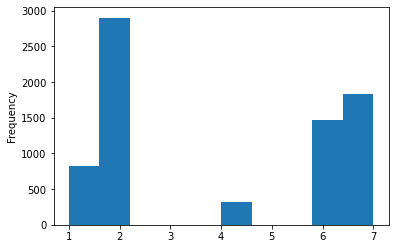

In [129]:
merge_jam_level['road_type'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

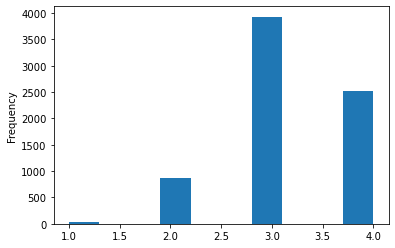

In [130]:
merge_jam_level['jam_level'].plot(kind='hist')

In [126]:
merge_jam_level[merge_jam_level['street_y'].isna()==True]['s2token_15'].nunique()

1180

In [162]:
merge_speed

,s2token_15,x,y,z,day,month,hour_y,street_y,road_type,jam_level,speed_decrease_%,Freq
0,2e6992a84,0.994031,0.108207,-0.013921,25,11,18,Hankam Raya,2.0,4.0,59.383562,280.0
1,2e68e62f4,0.561143,0.574345,-0.596025,29,11,20,Asia Afrika,7.0,3.0,42.996743,105.0
2,2e68e81a4,0.525794,0.591784,-0.611009,27,11,10,N11 Soekarno-Hatta,6.0,3.0,14.737794,32.0
3,2e69eec04,0.996602,-0.021315,-0.079557,24,11,7,NaN,NaN,NaN,NaN,NaN
4,2e698e4a4,0.972344,0.233176,0.013294,27,11,8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13836,2e68dd414,0.520341,0.621773,-0.585357,26,11,5,Jenderal AH Nasution,6.0,3.0,49.233465,17.0
13837,2e698541c,0.953392,0.301451,0.013105,24,11,22,NaN,NaN,NaN,NaN,NaN
13838,2e69e8e0c,0.991486,-0.047556,-0.121218,24,11,10,Muhtar Raya,7.0,2.0,13.827655,136.0
13839,2e699a1cc,0.951855,0.294791,-0.084091,24,11,18,Cibarusah Raya,7.0,3.0,32.158055,52.0


In [161]:
merge_speed.to_csv('merge_speed.csv')

In [165]:
ready.to_csv('ready.csv')

In [167]:
ready.isna().sum()/len(ready)

s2token_15             0.000000
lat                    0.000000
lon                    0.000000
day                    0.000000
month                  0.000000
Labels                 0.000000
hour_y                 0.000000
street_y               0.009005
road_type              0.000000
jam_level              0.000000
speed_decresement_%    0.000000
dtype: float64

In [153]:
ready_clean.to_csv('ready_clean.csv', index=False)
print('done')
db_street.to_csv('db_street.csv', index=False)
print('done')
db_road_type.to_csv('db_road_type.csv', index=False)
print('done')
db_jam_level.to_csv('db_jam_level.csv', index=False)
print('done')
db_speed.to_csv('db_speed.csv', index=False)
print('done')
db_severity.to_csv('db_jam_level.csv', index=False)
print('done')

done
done
done
done
done
done


In [128]:
merge_jam_level.to_csv('test_set.csv')